# 1. Import libraries

In [1]:
import numpy as np
import pandas as pd
import requests
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from datetime import timedelta

try:
    import holidays
except:
    !pip install holidays
    import holidays
try:
    import xgboost as xgb
except:
    !pip install xgboost
    import xgboost as xgb
try:
    from lunardate import LunarDate
except:
    !pip install lunardate
    from lunardate import LunarDate

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.fft import fft
import warnings

warnings.simplefilter(action='ignore')

# 2. Load data

In [2]:
# Define url path to CSV
annex1 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex1.csv'
annex2 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex2.csv'
annex3 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex3.csv'
annex4 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex4.csv'

In [3]:
def get_df_from_url(url):
    # Create request response
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Create a file-like object from the raw content
        csv_content = StringIO(response.text)

        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_content)

        # Return DataFrame
        return df
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")

df_item = get_df_from_url(annex1)
df_transaction = get_df_from_url(annex2)
df_wholesale = get_df_from_url(annex3)
df_loss = get_df_from_url(annex4)

# 3. Merge and aggregate data

In [4]:
def merge_all_df(df_transaction: pd.DataFrame = df_transaction,
                 df_item: pd.DataFrame = df_item,
                 df_wholesale: pd.DataFrame = df_wholesale,
                 df_loss: pd.DataFrame = df_loss):

    df_merge = df_transaction.merge(df_item,
                                    how = 'left',
                                    on = 'Item Code')
    df_merge = df_merge.merge(df_wholesale,
                            how = 'left',
                            on = ['Date', 'Item Code'])
    df_merge = df_merge.merge(df_loss.drop('Item Name', axis = 1),
                            how = 'left',
                            on = 'Item Code')
    
    return df_merge

df_merge = merge_all_df()

In [5]:
# Create Sales column
df_merge['Sales'] = df_merge['Unit Selling Price (RMB/kg)'] * df_merge['Quantity Sold (kilo)']

# Aggregate as new table
df_agg = df_merge.groupby(['Date', 'Category Code'], as_index = False)['Sales'].sum()
df_agg.head()

,Date,Category Code,Sales
0,2020-07-01,1011010101,1503.7896
1,2020-07-01,1011010201,592.5300
2,2020-07-01,1011010402,70.2838
3,2020-07-01,1011010501,176.8180
4,2020-07-01,1011010504,759.9902


# 4. Feature Engineering

In [6]:
def create_date_feature(df: pd.DataFrame,
                       date_column: str):
    # Convert the 'Date' column to datetime type
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].astype('datetime64[ns]')

    # Extract date components
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek  # Monday is 0 and Sunday is 6
    df['WeekNumber'] = df['Date'].dt.isocalendar().week
    df['Quarter'] = df['Date'].dt.quarter

    # df['Year'] = df['Year'].astype('category')
    # df['Month'] = df['Month'].astype('category')
    # df['Day'] = df['Day'].astype('category')
    # df['DayOfWeek'] = df['DayOfWeek'].astype('category')
    # df['WeekNumber'] = df['WeekNumber'].astype('category')
    # df['Quarter'] = df['Quarter'].astype('category')
    
    return df

def is_holiday(date_value):
    china_holidays = holidays.country_holidays('CN')
    value = 1 if date_value in china_holidays else 0
    return value

def create_lag_feature(df: pd.DataFrame,
                       days: int):
    
    df[f'lag_{days}'] = df['Sales'].shift(days)
    
    return df

def get_chinese_new_year_dates(start_year, end_year):
    chinese_new_year_dates = []

    for year in range(start_year, end_year + 1):
        lunar_date = LunarDate(year, 1, 1)
        cny_date = pd.Timestamp(lunar_date.toSolarDate())

        chinese_new_year_dates.append({'Chinese New Year Date': cny_date})

    chinese_new_year_df = pd.DataFrame(chinese_new_year_dates)
    chinese_new_year_df['Last Chinese New Year Date'] = chinese_new_year_df['Chinese New Year Date'].shift(1)
    chinese_new_year_df.dropna(subset=['Last Chinese New Year Date'], inplace = True)
    
    return chinese_new_year_df

def get_chinese_new_year_period(df, days):
    days = 7
    # new_years = df['Chinese New Year Date'].unique()
    # for new_year in new_years:
    new_year_dict = dict(zip(df['Chinese New Year Date'], df['Last Chinese New Year Date']))
    for this_year, last_year in new_year_dict.items():
        for day in range(-days, days + 1):
            if day != 0:
                df = pd.concat([df, pd.DataFrame({'Chinese New Year Date': [this_year + timedelta(days = day)],
                                                  'Last Chinese New Year Date': [last_year + timedelta(days = day)]})],
                               axis = 0,
                               ignore_index = True)
    return df

def create_last_new_year_feature(df: pd.DataFrame,
                                 days_before_after: int):
    
    # Get start and end year to generate Chinese New Year DataFrame from input data
    df['Date'] = df['Date'].astype('datetime64[ns]')
    df['Date'] = pd.to_datetime(df['Date'])
    start_year = df['Date'].min().year
    end_year = df['Date'].max().year
    
    # Get Chinese New Year DataFrame
    df_chinese_new_year = get_chinese_new_year_dates(start_year = start_year,
                                                     end_year = end_year)
    df_chinese_new_year_period = get_chinese_new_year_period(df = df_chinese_new_year,
                                                             days = 7)

    # Cast date column
    df['Date'] = pd.to_datetime(df['Date'])

    # Merge current new year date with last new year date
    df_last_new_year = df.copy()
    df_last_new_year = df_last_new_year.merge(df_chinese_new_year_period,
                                              how = 'left',
                                              left_on = 'Date',
                                              right_on = 'Last Chinese New Year Date')
    # Cleanup DataFrame
    df_last_new_year = df_last_new_year[~df_last_new_year['Last Chinese New Year Date'].isna()][['Chinese New Year Date', 'Category Code', 'Sales']]

    # Change column name before merge avoiding duplicated columns
    df_last_new_year.columns = ['Date', 'Category Code', 'Last New Year Sales']

    # Merge current new year with current new year to get "Last New Year Sales"
    df = df.merge(df_last_new_year,
                  on = ['Date', 'Category Code'],
                  how = 'left')

    return df

In [7]:
def category_feature_engineering(df_category: pd.DataFrame):
    df_category = create_date_feature(df_category,
                                    date_column = 'Date')
    df_category = create_lag_feature(df = df_category,
                                    days = 364)
    df_category = create_lag_feature(df = df_category,
                                    days = 28)
    df_category = create_lag_feature(df = df_category,
                                    days = 7)
    df_category = create_last_new_year_feature(df = df_category,
                                            days_before_after = 7)
    df_category['is_holiday'] = df_category['Date'].apply(is_holiday)

    df_final = df_category.drop(['Date', 'Category Code'], axis = 1)

    return df_final

# 5. Train and evaluate

## 6.1 Train

In [8]:
# categories = df_agg['Category Code'].unique()
# for category in categories:
scaler = StandardScaler()
category = 1011010101
df_category = df_agg[df_agg['Category Code'] == category]

# Feature Engineering
df_category = create_date_feature(df_category,
                                  date_column = 'Date')
df_category = create_lag_feature(df = df_category,
                                 days = 364)
df_category = create_last_new_year_feature(df = df_category,
                                           days_before_after = 7)
df_final = df_category.drop(['Date', 'Category Code'], axis = 1)

######################################################
################ CATEGORY: 1011010101 ################
######################################################

RMSE: 292.64 | Normalized RMSE: 0.14 | MAPE: 26.91 %


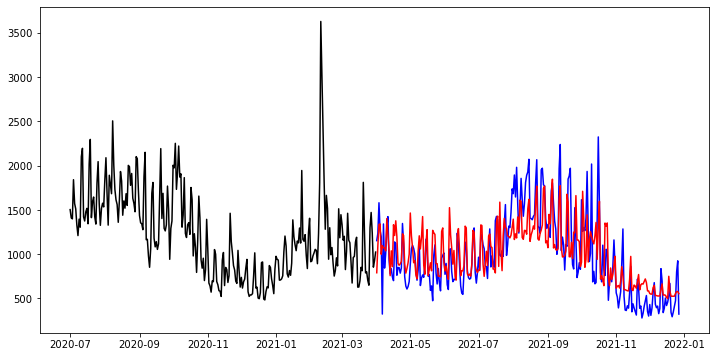

RMSE: 269.61 | Normalized RMSE: 0.11 | MAPE: 28.02 %


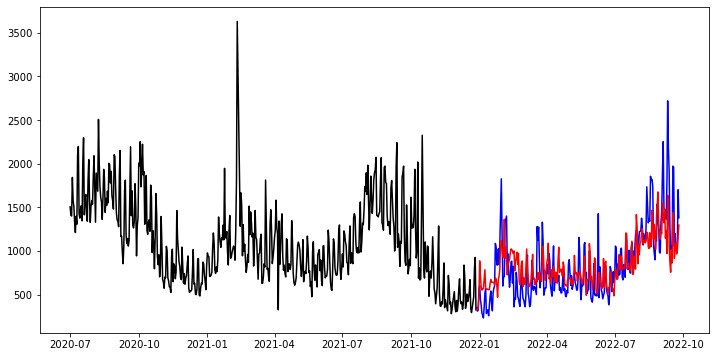

RMSE: 468.26 | Normalized RMSE: 0.12 | MAPE: 33.67 %


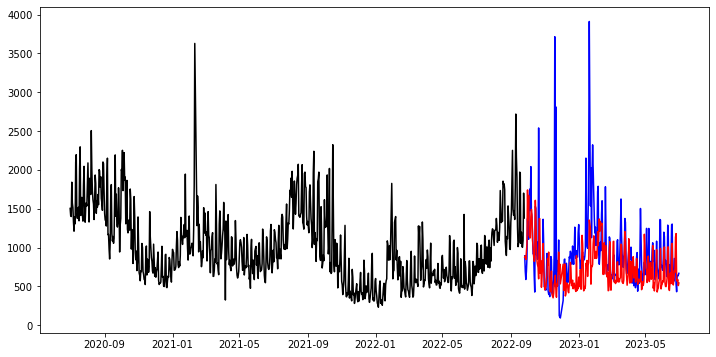


>>> Category RMSE: 343.50
>>> Category Normalized RMSE: 0.12
>>> Category MAPE: 29.54 %

######################################################
################ CATEGORY: 1011010201 ################
######################################################

RMSE: 137.76 | Normalized RMSE: 0.20 | MAPE: 72.90 %


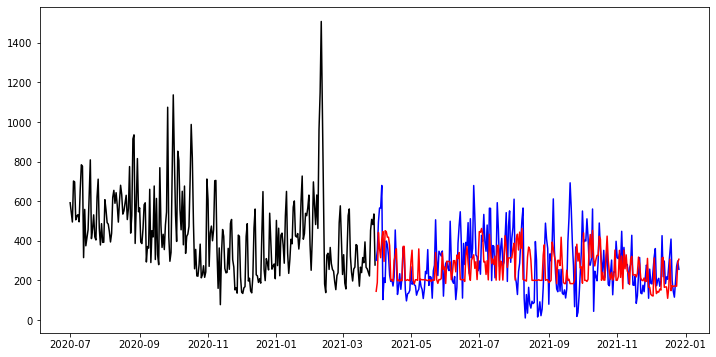

RMSE: 237.23 | Normalized RMSE: 0.16 | MAPE: 58.45 %


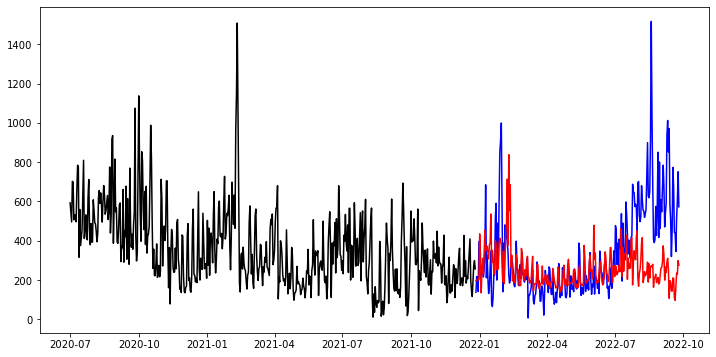

RMSE: 179.66 | Normalized RMSE: 0.12 | MAPE: 51.50 %


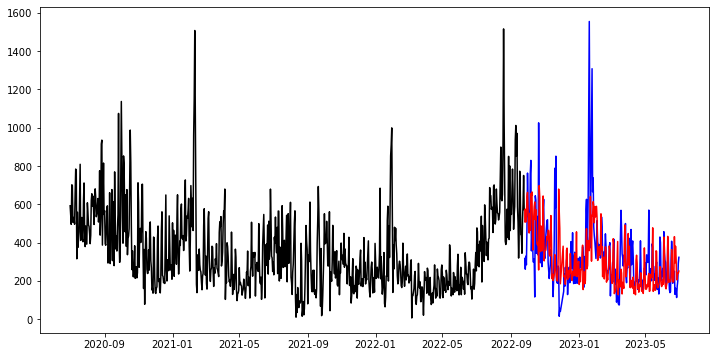


>>> Category RMSE: 184.88
>>> Category Normalized RMSE: 0.16
>>> Category MAPE: 60.95 %

######################################################
################ CATEGORY: 1011010402 ################
######################################################

RMSE: 122.47 | Normalized RMSE: 0.17 | MAPE: 61.56 %


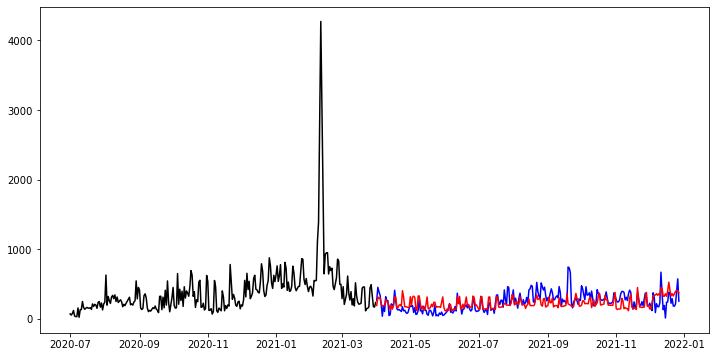

RMSE: 406.29 | Normalized RMSE: 0.15 | MAPE: 79.88 %


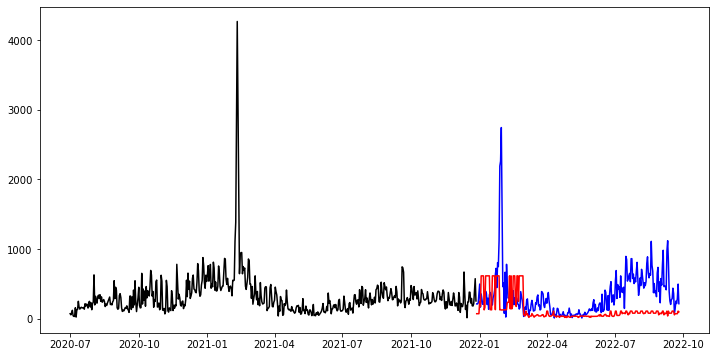

RMSE: 221.84 | Normalized RMSE: 0.11 | MAPE: 53.73 %


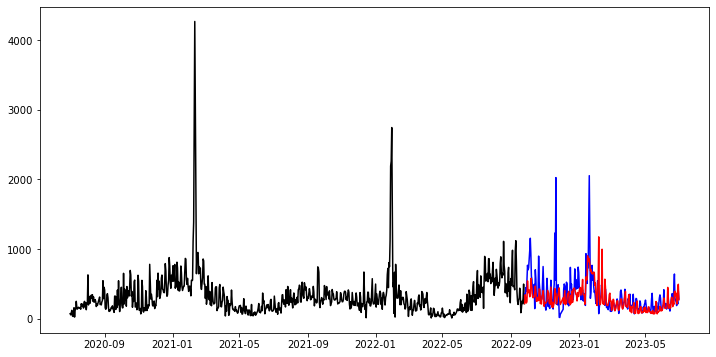


>>> Category RMSE: 250.20
>>> Category Normalized RMSE: 0.14
>>> Category MAPE: 65.06 %

######################################################
################ CATEGORY: 1011010501 ################
######################################################

RMSE: 83.78 | Normalized RMSE: 0.23 | MAPE: 32.95 %


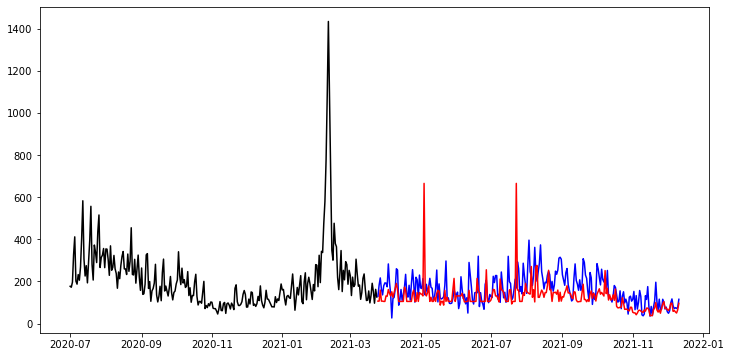

RMSE: 173.64 | Normalized RMSE: 0.12 | MAPE: 44.79 %


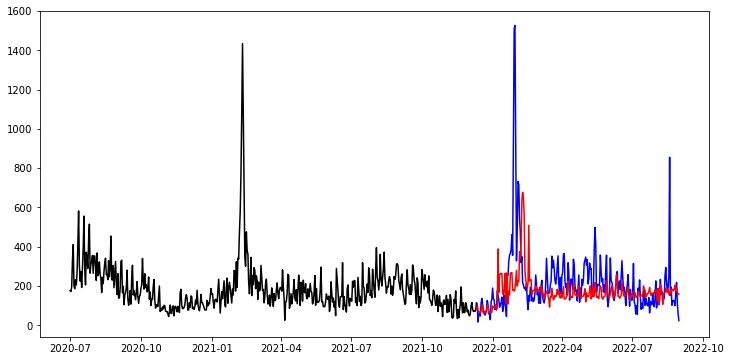

RMSE: 98.88 | Normalized RMSE: 0.09 | MAPE: 99.85 %


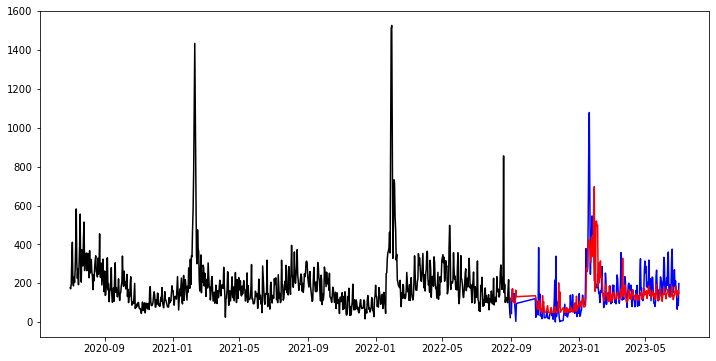


>>> Category RMSE: 118.77
>>> Category Normalized RMSE: 0.14
>>> Category MAPE: 59.20 %

######################################################
################ CATEGORY: 1011010504 ################
######################################################

RMSE: 118.28 | Normalized RMSE: 0.14 | MAPE: 25.16 %


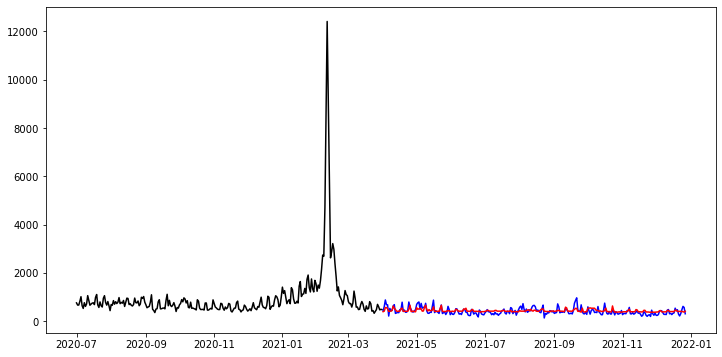

RMSE: 824.97 | Normalized RMSE: 0.11 | MAPE: 58.46 %


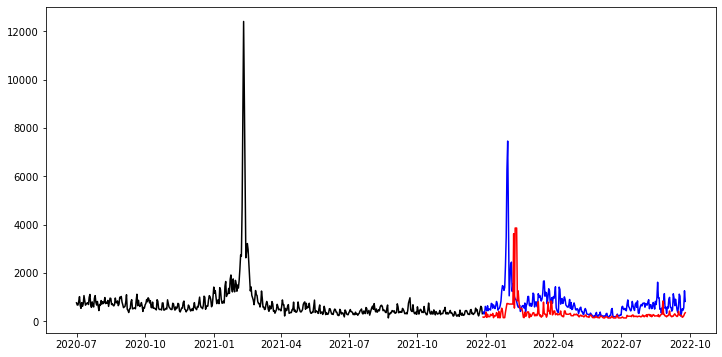

RMSE: 606.01 | Normalized RMSE: 0.10 | MAPE: 45.12 %


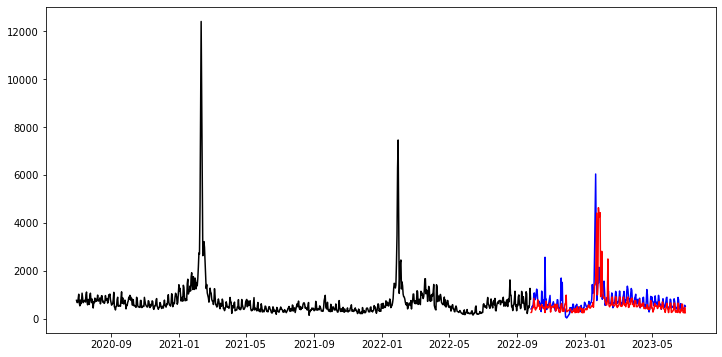


>>> Category RMSE: 516.42
>>> Category Normalized RMSE: 0.12
>>> Category MAPE: 42.91 %

######################################################
################ CATEGORY: 1011010801 ################
######################################################

RMSE: 206.73 | Normalized RMSE: 0.15 | MAPE: 43.76 %


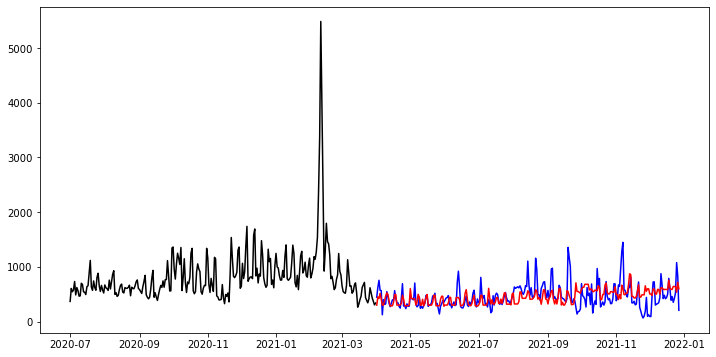

RMSE: 255.18 | Normalized RMSE: 0.14 | MAPE: 36.21 %


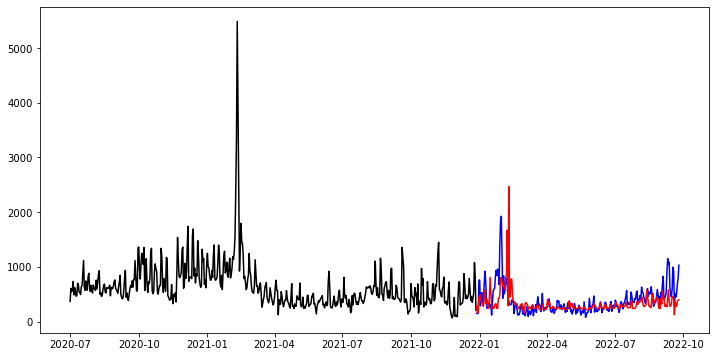

RMSE: 403.63 | Normalized RMSE: 0.11 | MAPE: 46.52 %


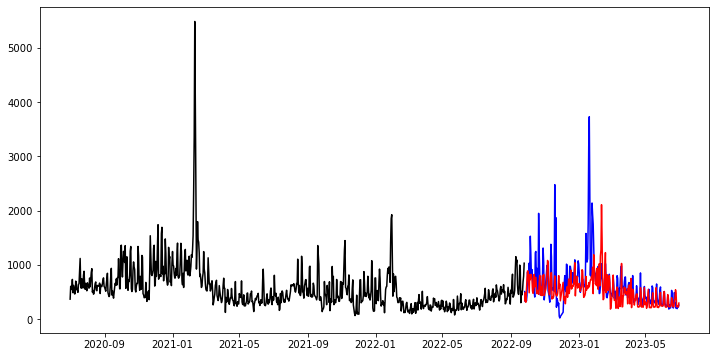


>>> Category RMSE: 288.51
>>> Category Normalized RMSE: 0.13
>>> Category MAPE: 42.17 %

############ AVERAGE RMSE: 283.7138040349273 ############


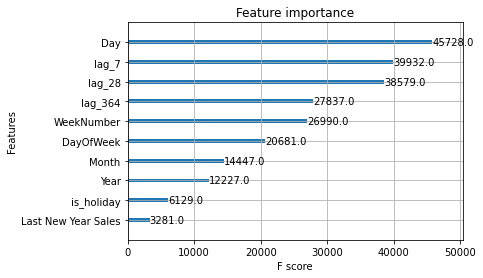

,Category,RMSE,Normalized RMSE,MAPE
0,1011010101,343.500656,0.124715,0.295355
1,1011010201,184.881245,0.158506,0.609465
2,1011010402,250.199348,0.141477,0.650559
3,1011010501,118.766808,0.144573,0.591967
4,1011010504,516.420163,0.118531,0.429102
5,1011010801,288.514604,0.132124,0.421653


Average RMSE: 283.71
Average Normalized RMSE: 0.14
Average MAPE: 49.97 %


In [9]:
scaler = StandardScaler()
category_result_dict = {'Category': [],
                      'RMSE': [],
                      'Normalized RMSE': [],
                      'MAPE': []}
all_rmse = []
xgb_r = xgb.XGBRegressor(
    n_estimators = 10000,
    eval_metrics = mean_squared_error,
    early_stopping_rounds = 200,
    learning_rate = 0.001,
    max_depth = 6,
    random_state = 244
)

categories = df_agg['Category Code'].unique()
for category in categories:
    category_rmse = []
    category_normalized_rmse = []
    category_mape = []
    df_category = df_agg[df_agg['Category Code'] == category]

    print('######################################################')
    print(f'################ CATEGORY: {category} ################')
    print('######################################################\n')

    # Feature Engineering
    df_final = category_feature_engineering(df_category = df_category)

    # Start Training Loop
    X = df_final.drop('Sales', axis = 1)
    y = df_final[['Sales']]
    n_splits = 3
    tscv = TimeSeriesSplit(n_splits = n_splits)
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Scale X
        X_train[X_train.columns] = scaler.fit_transform(X_train)
        X_test[X_test.columns] = scaler.transform(X_test)
        
        # Fit the model
        xgb_r.fit(X = X_train,
                  y = y_train,
                  eval_set = [(X_train, y_train), (X_test, y_test)],
                  verbose = False)
        
        # Predict
        y_pred = xgb_r.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        normalized_rmse = rmse / (float(y_test.max()) - float(y_test.min()))
        mape = mean_absolute_percentage_error(y_true = y_test, y_pred = y_pred)


        category_rmse.append(rmse)
        category_normalized_rmse.append(normalized_rmse)
        category_mape.append(mape)
        all_rmse.append(rmse)

        print(f'RMSE: {rmse:.2f} | Normalized RMSE: {normalized_rmse:.2f} | MAPE: {mape*100:.2f} %')
        
        # Plot True vs. Predicted Labelse
        plt.figure(figsize=(12, 6))
        plt.plot(df_category.iloc[train_index]['Date'], y_train, c = 'black')
        plt.plot(df_category.iloc[test_index]['Date'], y_test, c = 'b')
        plt.plot(df_category.iloc[test_index]['Date'], y_pred, c = 'r')
        plt.show()
    
    category_result_dict['Category'].append(category)
    category_result_dict['RMSE'].append(sum(category_rmse) / len(category_rmse))
    category_result_dict['Normalized RMSE'].append(sum(category_normalized_rmse) / len(category_normalized_rmse))
    category_result_dict['MAPE'].append(sum(category_mape) / len(category_mape))
    

    print(f'\n>>> Category RMSE: {(sum(category_rmse) / len(category_rmse)):.2f}')
    print(f'>>> Category Normalized RMSE: {(sum(category_normalized_rmse) / len(category_normalized_rmse)):.2f}')
    print(f'>>> Category MAPE: {(sum(category_mape) / len(category_mape)) * 100:.2f} %\n')

print(f'############ AVERAGE RMSE: {sum(all_rmse) / len(all_rmse)} ############')
xgb.plot_importance(xgb_r)
plt.show()
display(pd.DataFrame(category_result_dict))
print(f'Average RMSE: {(sum(category_result_dict["RMSE"]) / len(category_result_dict["RMSE"])):.2f}')
print(f'Average Normalized RMSE: {(sum(category_result_dict["Normalized RMSE"]) / len(category_result_dict["Normalized RMSE"])):.2f}')
print(f'Average MAPE: {(sum(category_result_dict["MAPE"]) / len(category_result_dict["MAPE"])) * 100:.2f} %')

In [81]:
def train_evaluate(n_splits, xgb_r):

    categories = df_agg['Category Code'].unique()
    for category in categories:
        category_rmse = []
        category_normalized_rmse = []
        category_mape = []
        df_category = df_agg[df_agg['Category Code'] == category]

        print('######################################################')
        print(f'################ CATEGORY: {category} ################')
        print('######################################################\n')

        # Feature Engineering
        df_final = category_feature_engineering(df_category = df_category)

        # Start Training Loop
        X = df_final.drop('Sales', axis = 1)
        y = df_final[['Sales']]
        n_splits = n_splits
        tscv = TimeSeriesSplit(n_splits = n_splits)
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Scale X
            X_train[X_train.columns] = scaler.fit_transform(X_train)
            X_test[X_test.columns] = scaler.transform(X_test)
            
            # Fit the model
            xgb_r.fit(X = X_train,
                    y = y_train,
                    eval_set = [(X_train, y_train), (X_test, y_test)],
                    verbose = False)
            
            # Predict
            y_pred = xgb_r.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            normalized_rmse = rmse / (float(y_test.max()) - float(y_test.min()))
            mape = mean_absolute_percentage_error(y_true = y_test, y_pred = y_pred)


            category_rmse.append(rmse)
            category_normalized_rmse.append(normalized_rmse)
            category_mape.append(mape)
            all_rmse.append(rmse)

            print(f'RMSE: {rmse:.2f} | Normalized RMSE: {normalized_rmse:.2f} | MAPE: {mape*100:.2f} %')
            
            # Plot True vs. Predicted Labelse
            # plt.figure(figsize=(12, 6))
            # plt.plot(df_category.iloc[train_index]['Date'], y_train, c = 'black')
            # plt.plot(df_category.iloc[test_index]['Date'], y_test, c = 'b')
            # plt.plot(df_category.iloc[test_index]['Date'], y_pred, c = 'r')
            # plt.show()
        
        category_result_dict['Category'].append(category)
        category_result_dict['RMSE'].append(sum(category_rmse) / len(category_rmse))
        category_result_dict['Normalized RMSE'].append(sum(category_normalized_rmse) / len(category_normalized_rmse))
        category_result_dict['MAPE'].append(sum(category_mape) / len(category_mape))
        

        print(f'\n>>> Category RMSE: {(sum(category_rmse) / len(category_rmse)):.2f}')
        print(f'>>> Category Normalized RMSE: {(sum(category_normalized_rmse) / len(category_normalized_rmse)):.2f}')
        print(f'>>> Category MAPE: {(sum(category_mape) / len(category_mape)) * 100:.2f} %\n')

    print(f'############ AVERAGE RMSE: {sum(all_rmse) / len(all_rmse)} ############')
    xgb.plot_importance(xgb_r)
    plt.show()
    display(pd.DataFrame(category_result_dict))
    print(f'Average RMSE: {(sum(category_result_dict["RMSE"]) / len(category_result_dict["RMSE"])):.2f}')
    print(f'Average Normalized RMSE: {(sum(category_result_dict["Normalized RMSE"]) / len(category_result_dict["Normalized RMSE"])):.2f}')
    print(f'Average MAPE: {(sum(category_result_dict["MAPE"]) / len(category_result_dict["MAPE"])) * 100:.2f} %')

In [82]:
category_result_dict = {'Category': [],
                      'RMSE': [],
                      'Normalized RMSE': [],
                      'MAPE': []}
all_rmse = []
xgb_r = xgb.XGBRegressor(
    n_estimators = 10000,
    eval_metrics = mean_squared_error,
    early_stopping_rounds = 200,
    learning_rate = 0.001,
    max_depth = 6,
    random_state = 244
)
n_splits = 3
train_evaluate(n_splits = n_splits, xgb_r = xgb_r)

######################################################
################ CATEGORY: 1011010101 ################
######################################################



TypeError: 'dict' object is not callable

######################################################
################ CATEGORY: 1011010101 ################
######################################################

RMSE: 422.02 | Normalized RMSE: 0.20 | MAPE: 47.40 %


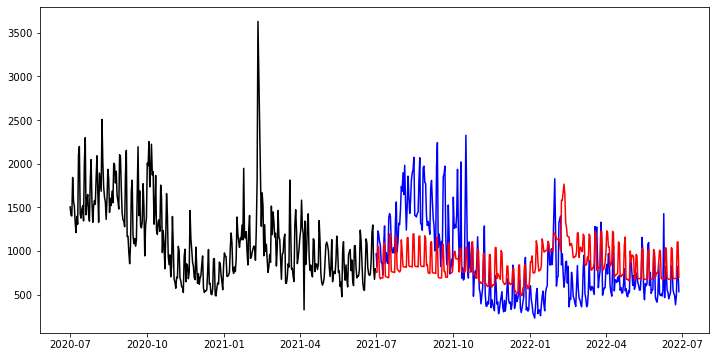

RMSE: 477.92 | Normalized RMSE: 0.13 | MAPE: 31.45 %


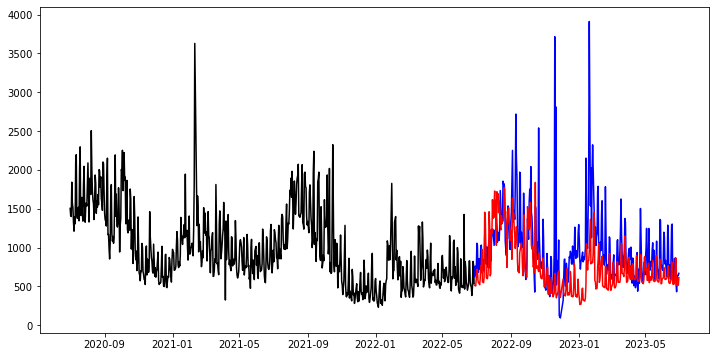


>>> Category RMSE: 449.97
>>> Category Normalized RMSE: 0.16
>>> Category MAPE: 39.42 %

######################################################
################ CATEGORY: 1011010201 ################
######################################################

RMSE: 132.52 | Normalized RMSE: 0.13 | MAPE: 75.37 %


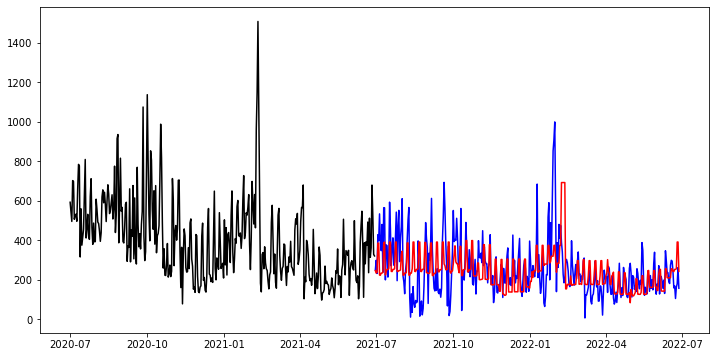

RMSE: 249.43 | Normalized RMSE: 0.16 | MAPE: 43.28 %


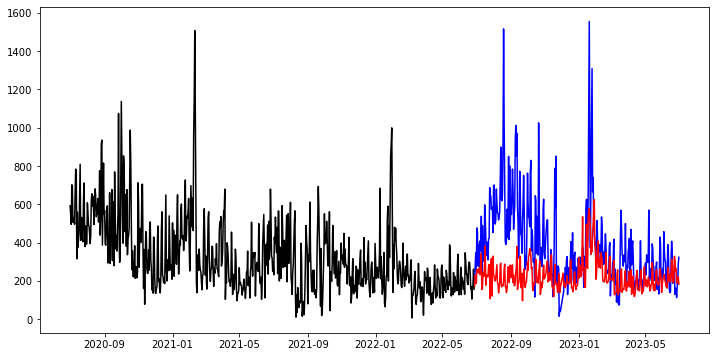


>>> Category RMSE: 190.98
>>> Category Normalized RMSE: 0.15
>>> Category MAPE: 59.33 %

######################################################
################ CATEGORY: 1011010402 ################
######################################################

RMSE: 277.61 | Normalized RMSE: 0.10 | MAPE: 63.89 %


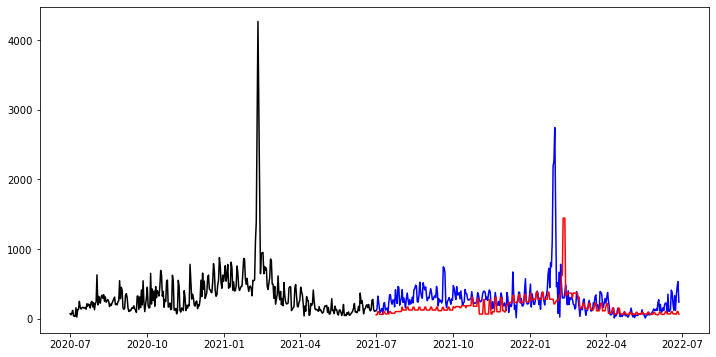

RMSE: 249.01 | Normalized RMSE: 0.12 | MAPE: 49.41 %


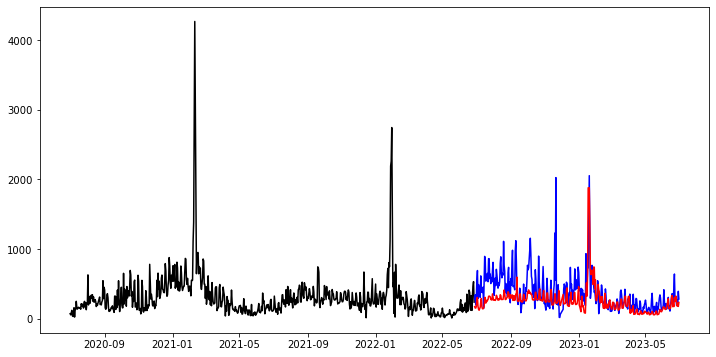


>>> Category RMSE: 263.31
>>> Category Normalized RMSE: 0.11
>>> Category MAPE: 56.65 %

######################################################
################ CATEGORY: 1011010501 ################
######################################################

RMSE: 156.73 | Normalized RMSE: 0.10 | MAPE: 37.75 %


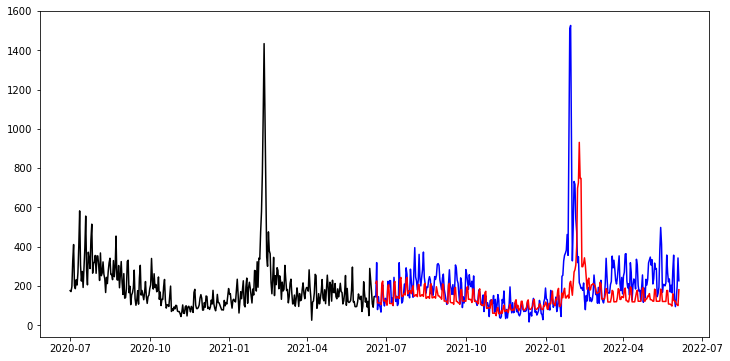

RMSE: 87.72 | Normalized RMSE: 0.08 | MAPE: 90.33 %


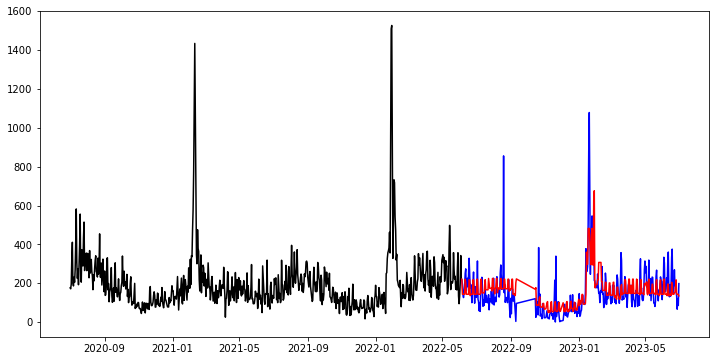


>>> Category RMSE: 122.22
>>> Category Normalized RMSE: 0.09
>>> Category MAPE: 64.04 %

######################################################
################ CATEGORY: 1011010504 ################
######################################################

RMSE: 654.06 | Normalized RMSE: 0.09 | MAPE: 40.84 %


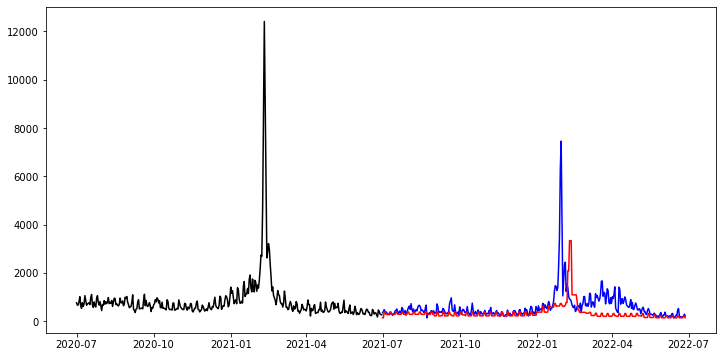

RMSE: 539.73 | Normalized RMSE: 0.09 | MAPE: 53.01 %


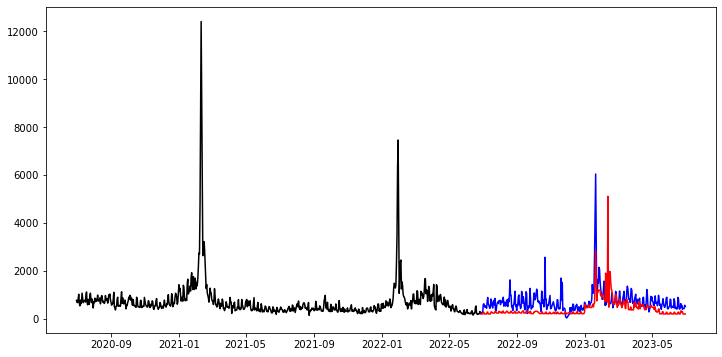


>>> Category RMSE: 596.90
>>> Category Normalized RMSE: 0.09
>>> Category MAPE: 46.93 %

######################################################
################ CATEGORY: 1011010801 ################
######################################################

RMSE: 288.50 | Normalized RMSE: 0.16 | MAPE: 52.50 %


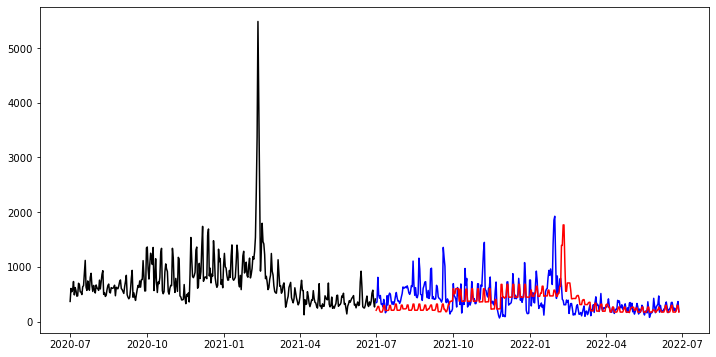

RMSE: 401.50 | Normalized RMSE: 0.11 | MAPE: 42.47 %


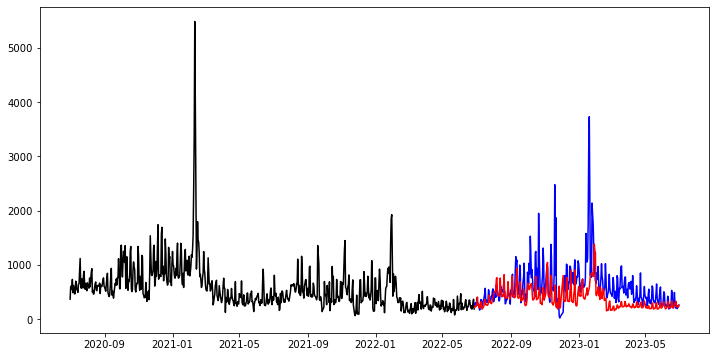


>>> Category RMSE: 345.00
>>> Category Normalized RMSE: 0.13
>>> Category MAPE: 47.49 %

############ AVERAGE RMSE: 328.0626491868426 ############


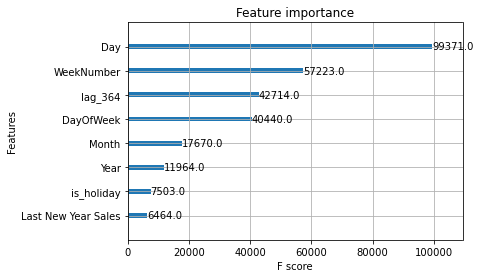

,Category,RMSE,Normalized RMSE,MAPE
0,1011010101,449.970420,0.163379,0.394248
1,1011010201,190.976032,0.147703,0.593252
2,1011010402,263.306676,0.111729,0.566479
3,1011010501,122.224005,0.092669,0.640407
4,1011010504,596.895086,0.089558,0.469256
5,1011010801,345.003676,0.131686,0.474860


Average RMSE: 328.06
Average Normalized RMSE: 0.12
Average MAPE: 52.31 %


In [67]:
category_result_dict = {'Category': [],
                      'RMSE': [],
                      'Normalized RMSE': [],
                      'MAPE': []}
all_rmse = []
xgb_r = xgb.XGBRegressor(
    n_estimators = 10000,
    eval_metrics = mean_squared_error,
    early_stopping_rounds = 200,
    learning_rate = 0.001,
    max_depth = 6,
    random_state = 244
)
n_splits = 2
train_evaluate(n_splits = n_splits, xgb_r = xgb_r)

In [68]:
dict ={'1': 2, '2':3}
exec(f'best_params_{category} = dict') 

# 7. Results